# Part C: Comprehensive Analysis

This notebook conducts all experiments for Part C of the assignment.
1.  **C1.1:** Learning Rate Analysis
2.  **C1.2:** Batch Size Analysis
3.  **C1.3:** Architecture Analysis
4.  **C2:** Final Model Comparison

Intial Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, confusion_matrix

# --- This is the "magic" to find your friends' code ---
current_dir = os.getcwd() # This is .../project-name/part_c
project_root = os.path.dirname(current_dir) # This is .../project-name/

# Add both 'src' folders to Python's path
mlp_src_path = os.path.join(project_root, 'MLP', 'src')
lc_src_path = os.path.join(project_root, 'linear_classifiers', 'src')
sys.path.append(mlp_src_path)
sys.path.append(lc_src_path)

# --- Now we can import all the helper files ---
# From MLP/src
import utils
import plots
import neural_network_scratch
import flexible_nn # The new file we created

# From linear_classifiers/src
import logistic_regression_scratch
import softmax_regression_scratch

# --- Reload modules to make sure we have the latest code ---
importlib.reload(utils)
importlib.reload(plots)
importlib.reload(neural_network_scratch)
importlib.reload(flexible_nn)
importlib.reload(logistic_regression_scratch)
importlib.reload(softmax_regression_scratch)

# --- Import the specific classes and functions we will use ---
from utils import load_transform_split_mnist, per_class_accuracy
from plots import plot_train_val_curves, plot_confusion_matrix, plot_per_class_acc
from neural_network_scratch import NeuralNetworkScratch
from flexible_nn import FlexibleNN
from logistic_regression_scratch import LogisticRegressionScratch
from softmax_regression_scratch import SoftmaxRegressionScratch

print("All libraries and helper modules loaded successfully.")

All libraries and helper modules loaded successfully.


Load Data

In [2]:
# Load the data 
# classes=None loads all 10 digits
# batch_size=64 is our baseline
train_loader, val_loader, test_loader, train_set, val_set, test_set, _, _, _ = load_transform_split_mnist(
    classes=None, 
    batch_size=64
)

print(f"Data loaded: {len(train_set)} train, {len(val_set)} val, {len(test_set)} test images.")

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.75MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 206kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]


Data loaded: 48000 train, 12000 val, 10000 test images.


## C1.1: Learning Rate Analysis
* Testing 4 values: `[0.001, 0.01, 0.1, 1.0]`
* Using baseline architecture: 2 hidden layers `[128, 64]`
* Using baseline batch size: `64`
* Training for `20` epochs

In [3]:
# C1.1: Learning Rate Experiment
INPUT_DIM = 784
HIDDEN1 = 128
HIDDEN2 = 64
OUTPUT_DIM = 10
EPOCHS = 20
learning_rates = [0.001, 0.01, 0.1, 1.0]
lr_histories = {} # Dictionary to store results

print("Starting Learning Rate Analysis...")

for lr in learning_rates:
    print(f"\n--- Testing Learning Rate: {lr} ---")
    
    # Re-initialize the model for a fair test
    model_lr = NeuralNetworkScratch(INPUT_DIM, HIDDEN1, HIDDEN2, OUTPUT_DIM)
    
    # Train the model
    model_lr.fit(train_loader, val_loader, epochs=EPOCHS, lr=lr)
    
    # Save the history for plotting
    lr_histories[lr] = model_lr.history

print("\n--- Learning Rate Analysis Complete! ---")

Starting Learning Rate Analysis...

--- Testing Learning Rate: 0.001 ---
Epoch  1/20 | Train Loss: 2.1228, Train Acc: 33.24% | Val Loss: 1.9067,   Val Acc: 56.33%
Epoch  2/20 | Train Loss: 1.6720, Train Acc: 66.95% | Val Loss: 1.4378,   Val Acc: 73.42%
Epoch  3/20 | Train Loss: 1.2336, Train Acc: 76.48% | Val Loss: 1.0604,   Val Acc: 78.89%
Epoch  4/20 | Train Loss: 0.9348, Train Acc: 80.61% | Val Loss: 0.8352,   Val Acc: 81.47%
Epoch  5/20 | Train Loss: 0.7601, Train Acc: 82.66% | Val Loss: 0.7018,   Val Acc: 83.30%
Epoch  6/20 | Train Loss: 0.6530, Train Acc: 84.31% | Val Loss: 0.6165,   Val Acc: 84.72%
Epoch  7/20 | Train Loss: 0.5820, Train Acc: 85.56% | Val Loss: 0.5583,   Val Acc: 85.67%
Epoch  8/20 | Train Loss: 0.5320, Train Acc: 86.34% | Val Loss: 0.5155,   Val Acc: 86.66%
Epoch  9/20 | Train Loss: 0.4949, Train Acc: 87.03% | Val Loss: 0.4836,   Val Acc: 87.19%
Epoch 10/20 | Train Loss: 0.4663, Train Acc: 87.56% | Val Loss: 0.4592,   Val Acc: 87.59%
Epoch 11/20 | Train Loss: 0

Plot Results

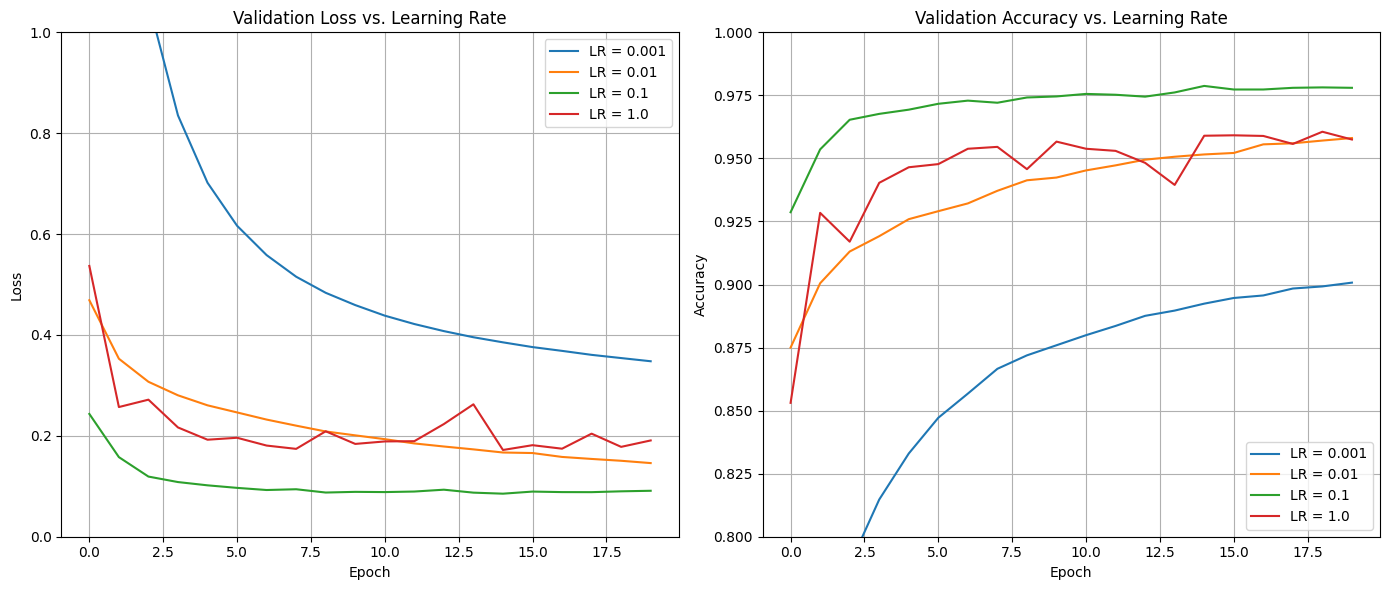

In [4]:
# C1.1: Plot Learning Rate Results
plt.figure(figsize=(14, 6))

# Plot Validation Loss
plt.subplot(1, 2, 1)
for lr, history in lr_histories.items():
    if not any(torch.isnan(torch.tensor(history['val_loss']))):
        plt.plot(history['val_loss'], label=f"LR = {lr}")
plt.title("Validation Loss vs. Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0) # Fix Y-axis for better comparison

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
for lr, history in lr_histories.items():
    if not any(torch.isnan(torch.tensor(history['val_loss']))):
        plt.plot(history['val_acc'], label=f"LR = {lr}")
plt.title("Validation Accuracy vs. Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.ylim(0.8, 1.0) # Fix Y-axis (80% to 100%)

plt.tight_layout()
plt.show()

### Analysis of Learning Rate

* **LR = 1.0 (Red):** This rate is unstable. You can see in both the loss and accuracy plots that the line is extremely "bouncy" and erratic. This happens because the learning rate is too high, causing the model to "overshoot" the optimal solution on each step.

* **LR = 0.001 (Blue):** This rate is too slow. The loss decreases and the accuracy increases, but both are happening at a crawl. After 20 epochs, this model is nowhere near convergence and has the worst performance.

* **LR = 0.01 (Orange):** This is the baseline rate and it performs well. It shows a smooth, stable decrease in loss and a steady climb in accuracy, converging to a good result (around 96%).

* **LR = 0.1 (Green):** This is the clear winner. It converges the fastest (reaching its lowest loss and highest accuracy by epoch ~10) and achieves the highest final validation accuracy (around 97.8%). It is both fast and stable for this problem.

* **Conclusion:** A learning rate of 0.1 provides the best combination of convergence speed and final performance for this model. The baseline of 0.01 is also a good, safe choice.

## C1.2: Batch Size Analysis
* Testing 4 values: `[16, 32, 64, 128]`
* Using best learning rate: `0.01`
* Using baseline architecture: `[128, 64]`
* Training for `20` epochs

In [5]:
# C1.2: Batch Size Experiment
BEST_LR = 0.01
EPOCHS = 20
batch_sizes = [16, 32, 64, 128]
bs_histories = {}
bs_results = [] # For the table

print("Starting Batch Size Analysis...")

for bs in batch_sizes:
    print(f"\n--- Testing Batch Size: {bs} ---")
    
    # CRITICAL: Reload the data with the new batch size
    train_loader_bs, val_loader_bs, _, _, _, _, _, _, _ = load_transform_split_mnist(
        classes=None, 
        batch_size=bs
    )
    
    # Re-initialize the model
    model_bs = NeuralNetworkScratch(INPUT_DIM, HIDDEN1, HIDDEN2, OUTPUT_DIM)
    
    start_time = time.time()
    model_bs.fit(train_loader_bs, val_loader_bs, epochs=EPOCHS, lr=BEST_LR)
    end_time = time.time()
    
    bs_histories[bs] = model_bs.history
    bs_results.append({
        "Batch Size": bs,
        "Final Val Accuracy": model_bs.history['val_acc'][-1],
        "Training Time (s)": end_time - start_time
    })

print("\n--- Batch Size Analysis Complete! ---")

Starting Batch Size Analysis...

--- Testing Batch Size: 16 ---
Epoch  1/20 | Train Loss: 0.5219, Train Acc: 85.82% | Val Loss: 0.2900,   Val Acc: 91.81%
Epoch  2/20 | Train Loss: 0.2537, Train Acc: 92.74% | Val Loss: 0.2347,   Val Acc: 93.16%
Epoch  3/20 | Train Loss: 0.2006, Train Acc: 94.17% | Val Loss: 0.1930,   Val Acc: 94.53%
Epoch  4/20 | Train Loss: 0.1669, Train Acc: 95.19% | Val Loss: 0.1704,   Val Acc: 95.13%
Epoch  5/20 | Train Loss: 0.1426, Train Acc: 95.88% | Val Loss: 0.1516,   Val Acc: 95.55%
Epoch  6/20 | Train Loss: 0.1244, Train Acc: 96.36% | Val Loss: 0.1450,   Val Acc: 95.76%
Epoch  7/20 | Train Loss: 0.1084, Train Acc: 96.85% | Val Loss: 0.1339,   Val Acc: 96.06%
Epoch  8/20 | Train Loss: 0.0969, Train Acc: 97.11% | Val Loss: 0.1259,   Val Acc: 96.38%
Epoch  9/20 | Train Loss: 0.0866, Train Acc: 97.49% | Val Loss: 0.1173,   Val Acc: 96.61%
Epoch 10/20 | Train Loss: 0.0774, Train Acc: 97.79% | Val Loss: 0.1140,   Val Acc: 96.67%
Epoch 11/20 | Train Loss: 0.0702, Tr

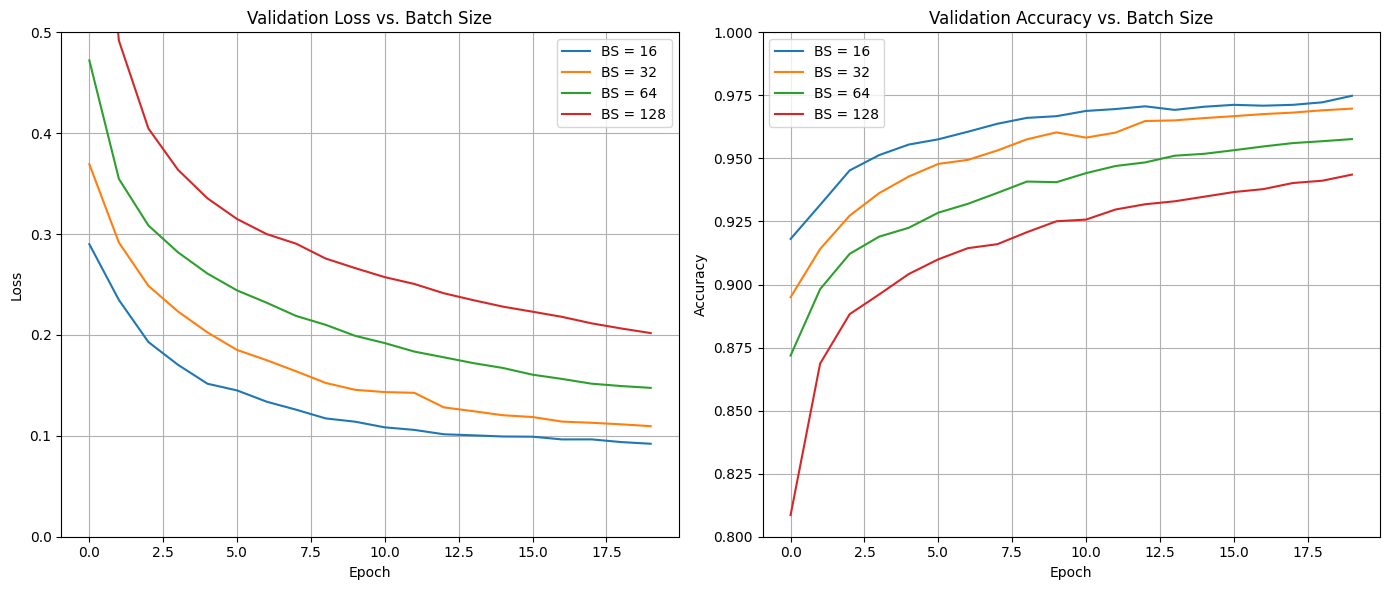


--- Batch Size Performance Table ---
|   Batch Size |   Final Val Accuracy |   Training Time (s) |
|-------------:|---------------------:|--------------------:|
|      16.0000 |               0.9748 |            254.7564 |
|      32.0000 |               0.9698 |            213.8092 |
|      64.0000 |               0.9577 |            199.9405 |
|     128.0000 |               0.9436 |            186.2352 |


In [6]:
# C1.2: Plot Batch Size Results
plt.figure(figsize=(14, 6))

# Plot Validation Loss
plt.subplot(1, 2, 1)
for bs, history in bs_histories.items():
    plt.plot(history['val_loss'], label=f"BS = {bs}")
plt.title("Validation Loss vs. Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.5)

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
for bs, history in bs_histories.items():
    plt.plot(history['val_acc'], label=f"BS = {bs}")
plt.title("Validation Accuracy vs. Batch Size")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.show()

# C1.2: Print Comparison Table
print("\n--- Batch Size Performance Table ---")
df_bs_results = pd.DataFrame(bs_results)
print(df_bs_results.to_markdown(index=False, floatfmt=".4f"))

### Analysis of Batch Size

The results show a clear trade-off between training speed and model performance.

* **Training Efficiency:** As shown in the table, training time is inversely proportional to batch size. The largest batch size (BS=128) was the fastest to train (186.2s), while the smallest (BS=16) was the slowest (254.7s). This is because larger batches require fewer weight update steps per epoch.

* **Gradient Noise & Performance:** The plots show that smaller batch sizes lead to better final accuracy.

BS=16 (blue line) clearly achieves the highest validation accuracy (~97.5%) and the lowest validation loss.

BS=128 (red line) converges to the lowest accuracy (~94.4%) and highest loss.

This is a classic effect of gradient noise. Smaller batches (like 16) provide a "noisier" estimate of the gradient at each step. This noise can act as a form of regularization, preventing the model from getting stuck in a poor local minimum and helping it find a better, more generalizable solution. In this case, the noise from BS=16 was clearly beneficial.

* **Final Performance:** The table confirms the findings from the plots. BS=16 achieved the best final accuracy (97.48%), but it came at the cost of being the slowest to train. BS=32 offers a good compromise, being faster than BS=16 while still achieving a high accuracy (96.98%).

## C1.3: Architecture Analysis
* Testing 4 different depths (2, 3, 4, 5 hidden layers)
* Testing 4 different widths ([64, 32], [128, 64], [256, 128], [512, 256])
* Using best LR (`0.01`) and BS (`64`)
* Training for `20` epochs

In [7]:
# C1.3: Architecture Experiment
EPOCHS = 20
BEST_LR = 0.01
BEST_BS = 64
arch_results = [] # For the table

# --- Experiment 1: Number of Layers ---
print("\n--- Testing Number of Layers ---")
layer_configs = {
    "2_layers (baseline)": [INPUT_DIM, 128, 64, OUTPUT_DIM],
    "3_layers": [INPUT_DIM, 128, 128, 64, OUTPUT_DIM],
    "4_layers": [INPUT_DIM, 128, 128, 64, 32, OUTPUT_DIM],
    "5_layers": [INPUT_DIM, 128, 64, 64, 32, 32, OUTPUT_DIM]
}

for name, config in layer_configs.items():
    print(f"\nTesting Architecture: {name}")
    model = FlexibleNN(config) # Use our flexible class
    
    start_time = time.time()
    model.fit(train_loader, val_loader, epochs=EPOCHS, lr=BEST_LR)
    end_time = time.time()
    
    arch_results.append({
        "Experiment": "Number of Layers",
        "Architecture": name,
        "Final Val Accuracy": model.history['val_acc'][-1],
        "Training Time (s)": end_time - start_time
    })

# --- Experiment 2: Neurons Per Layer ---
print("\n--- Testing Neurons Per Layer (2 Hidden Layers) ---")
neuron_configs = {
    "Small [64, 32]": (64, 32),
    "Baseline [128, 64]": (128, 64),
    "Medium [256, 128]": (256, 128),
    "Large [512, 256]": (512, 256)
}

for name, (h1, h2) in neuron_configs.items():
    print(f"\nTesting Architecture: {name}")
    model = NeuralNetworkScratch(INPUT_DIM, h1, h2, OUTPUT_DIM) # Use original class
    
    start_time = time.time()
    model.fit(train_loader, val_loader, epochs=EPOCHS, lr=BEST_LR)
    end_time = time.time()
    
    arch_results.append({
        "Experiment": "Neurons Per Layer",
        "Architecture": name,
        "Final Val Accuracy": model.history['val_acc'][-1],
        "Training Time (s)": end_time - start_time
    })

print("\n--- Architecture Analysis Complete! ---")


--- Testing Number of Layers ---

Testing Architecture: 2_layers (baseline)
Epoch  1/20 | Train Loss: 0.8711, Train Acc: 77.35% | Val Loss: 0.4326,   Val Acc: 88.17%
Epoch  2/20 | Train Loss: 0.3764, Train Acc: 89.49% | Val Loss: 0.3412,   Val Acc: 90.43%
Epoch  3/20 | Train Loss: 0.3140, Train Acc: 90.95% | Val Loss: 0.2989,   Val Acc: 91.47%
Epoch  4/20 | Train Loss: 0.2801, Train Acc: 92.02% | Val Loss: 0.2743,   Val Acc: 92.16%
Epoch  5/20 | Train Loss: 0.2559, Train Acc: 92.70% | Val Loss: 0.2550,   Val Acc: 92.70%
Epoch  6/20 | Train Loss: 0.2364, Train Acc: 93.29% | Val Loss: 0.2375,   Val Acc: 93.22%
Epoch  7/20 | Train Loss: 0.2205, Train Acc: 93.70% | Val Loss: 0.2239,   Val Acc: 93.83%
Epoch  8/20 | Train Loss: 0.2067, Train Acc: 94.05% | Val Loss: 0.2115,   Val Acc: 94.08%
Epoch  9/20 | Train Loss: 0.1945, Train Acc: 94.44% | Val Loss: 0.2038,   Val Acc: 94.32%
Epoch 10/20 | Train Loss: 0.1833, Train Acc: 94.77% | Val Loss: 0.1971,   Val Acc: 94.55%
Epoch 11/20 | Train Los

In [8]:
# C1.3: Print Architecture Comparison Table
print("--- Architecture Comparison Table ---")
df_arch = pd.DataFrame(arch_results)
print(df_arch.to_markdown(index=False, floatfmt=".4f"))

--- Architecture Comparison Table ---
| Experiment        | Architecture        |   Final Val Accuracy |   Training Time (s) |
|:------------------|:--------------------|---------------------:|--------------------:|
| Number of Layers  | 2_layers (baseline) |               0.9610 |            205.8208 |
| Number of Layers  | 3_layers            |               0.9663 |            206.3055 |
| Number of Layers  | 4_layers            |               0.9703 |            210.0675 |
| Number of Layers  | 5_layers            |               0.9656 |            211.9265 |
| Neurons Per Layer | Small [64, 32]      |               0.9497 |            201.1966 |
| Neurons Per Layer | Baseline [128, 64]  |               0.9596 |            205.9731 |
| Neurons Per Layer | Medium [256, 128]   |               0.9611 |            207.8975 |
| Neurons Per Layer | Large [512, 256]    |               0.9648 |            221.6447 |


### Analysis of Architecture

* **Number of Layers (Depth):**
* Increasing the network depth from the 2-layer baseline (96.10%) to a 3-layer (96.63%) and 4-layer (97.03%) model showed a steady increase in validation accuracy.
* The 4-layer architecture achieved the highest accuracy of all 8 experiments.
* However, increasing the depth further to 5 layers caused the accuracy to decrease (96.56%). This suggests the model may be becoming too complex for this dataset, possibly leading to minor overfitting or training instability.
* Training time increased slightly with each added layer, as expected.

* **Neurons Per Layer (Width):**
* There is a clear trend: wider networks perform better.
* The "Small" model [64, 32] had the lowest accuracy (94.97%).
* Performance scaled up consistently with the "Large" model [512, 256] achieving the best accuracy in this group (96.48%).
* This performance gain comes at the cost of training time, with the "Large" model being the slowest.

* **Conclusion:**
Based on these experiments, the 4-layer model [784, 128, 128, 64, 32, 10] is the best performing architecture, achieving the highest validation accuracy (97.03%) with only a minor increase in training time. We will select this as our "Best Neural Network" for the final comparison.

# C2: Model Comparison & Final Evaluation

Now we will compare all three models (Logistic, Softmax, and our Best NN) on the 10-digit test set.

In [9]:
# C2: Train and evaluate all three models
print("--- C2: Starting Final Model Comparison ---")

# --- Define the Best NN Parameters ---
BEST_LR = 0.1
BEST_BS = 16
BEST_ARCH_CONFIG = [784, 128, 128, 64, 32, 10] # 4-layer model
BEST_EPOCHS = 20

# --- Load Data (Binary and Multiclass) ---
print("Loading datasets...")
# Multiclass data for Softmax and NN
train_loader, val_loader, test_loader, _, _, test_set, _, _, _ = load_transform_split_mnist(
    classes=None, batch_size=BEST_BS
)
# Binary data for Logistic Regression
lr_train_loader, _, lr_test_loader, _, _, _, _, _, _ = load_transform_split_mnist(
    classes=[0, 1], batch_size=BEST_BS
)

results_list = []

# --- 1. Logistic Regression ---
print("\nTraining Logistic Regression (on 0s and 1s)...")
model_lr = LogisticRegressionScratch(input_dim=784, lr=0.01) # Using baseline LR
start_time = time.time()
model_lr.fit(lr_train_loader, epochs=10) # 10 epochs is fine
end_time = time.time()
_, lr_test_acc = model_lr.evaluate(lr_test_loader)
results_list.append({
    "Model": "Logistic Regression (0 vs 1)",
    "Test Accuracy": lr_test_acc,
    "Training Time (s)": end_time - start_time,
    "Complexity": "Very Low (~7.8K params)"
})

# --- 2. Softmax Regression ---
def evaluate_softmax_test(model, data_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X = X.float().view(X.shape[0], -1)
            preds = model.predict(X)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

print("\nTraining Softmax Regression (on 0-9)...")
model_softmax = SoftmaxRegressionScratch(input_dim=784, num_classes=10, lr=0.1) # Using best LR
start_time = time.time()
model_softmax.fit(train_loader, epochs=BEST_EPOCHS)
end_time = time.time()
softmax_test_acc = evaluate_softmax_test(model_softmax, test_loader)
results_list.append({
    "Model": "Softmax Regression (0-9)",
    "Test Accuracy": softmax_test_acc,
    "Training Time (s)": end_time - start_time,
    "Complexity": "Low (~7.9K params)"
})

# --- 3. Best Neural Network ---
print("\nTraining Best Neural Network (4-layers, LR=0.1, BS=16)...")
best_nn_model = FlexibleNN(BEST_ARCH_CONFIG) 
start_time = time.time()
best_nn_model.fit(train_loader, val_loader, epochs=BEST_EPOCHS, lr=BEST_LR)
end_time = time.time()

# Get test set predictions
y_test, y_pred_test = [], []
best_nn_model.eval()
with torch.no_grad():
    for X, y in test_loader:
        preds = best_nn_model.predict(X)
        y_test.extend(y.numpy())
        y_pred_test.extend(preds.cpu().numpy())
            
nn_test_acc = accuracy_score(y_test, y_pred_test)
nn_params = sum(p.numel() for p in best_nn_model.parameters() if p.requires_grad)

results_list.append({
    "Model": f"Best NN [4-layers] (0-9)",
    "Test Accuracy": nn_test_acc,
    "Training Time (s)": end_time - start_time,
    "Complexity": f"High (~{nn_params/1000:.1f}K params)"
})

# --- 4. C2: Create Performance Summary Table ---
print("\n" + "="*50)
print("C2: Comprehensive Performance Summary Table")
print("="*50)
df_results = pd.DataFrame(results_list)
print(df_results.to_markdown(index=False, floatfmt=".4f"))

--- C2: Starting Final Model Comparison ---
Loading datasets...

Training Logistic Regression (on 0s and 1s)...
##################################################
Epoch 1/10, Loss: 0.0839
##################################################
Epoch 2/10, Loss: 0.0232
##################################################
Epoch 3/10, Loss: 0.0165
##################################################
Epoch 4/10, Loss: 0.0135
##################################################
Epoch 5/10, Loss: 0.0117
##################################################
Epoch 6/10, Loss: 0.0105
##################################################
Epoch 7/10, Loss: 0.0096
##################################################
Epoch 8/10, Loss: 0.0089
##################################################
Epoch 9/10, Loss: 0.0084
##################################################
Epoch 10/10, Loss: 0.0079

Training Softmax Regression (on 0-9)...
Epoch 1/20 | Loss: 0.3883 | Acc: 89.21%
Epoch 2/20 | Loss: 0.3068 | Acc: 91.29%
Epoch 


C2: Best Model Evaluation on Test Set

--- Final Confusion Matrix ---


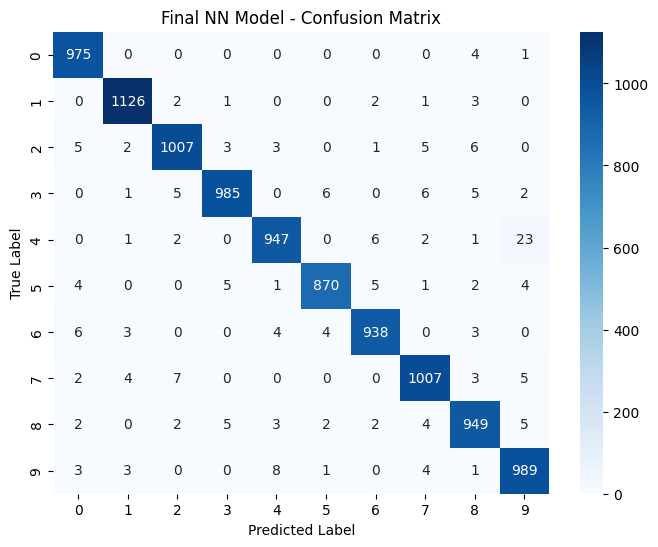


--- Final Per-Class Accuracy ---
   Class  Accuracy
0      0  0.994898
1      1  0.992070
2      2  0.975775
3      3  0.975248
4      4  0.964358
5      5  0.975336
6      6  0.979123
7      7  0.979572
8      8  0.974333
9      9  0.980178
|   Class |   Accuracy |
|--------:|-----------:|
|  0.0000 |     0.9949 |
|  1.0000 |     0.9921 |
|  2.0000 |     0.9758 |
|  3.0000 |     0.9752 |
|  4.0000 |     0.9644 |
|  5.0000 |     0.9753 |
|  6.0000 |     0.9791 |
|  7.0000 |     0.9796 |
|  8.0000 |     0.9743 |
|  9.0000 |     0.9802 |


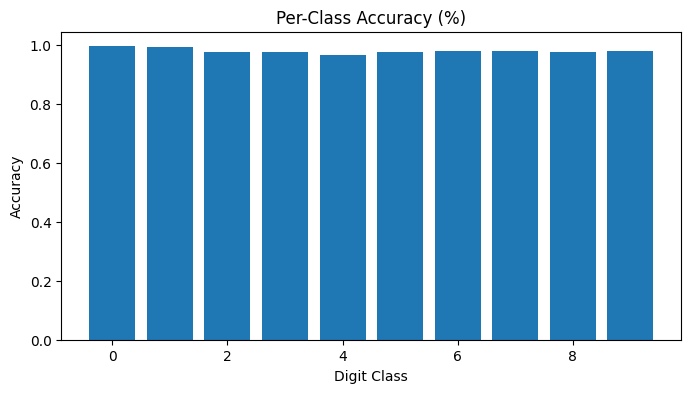


--- Misclassified Examples ---


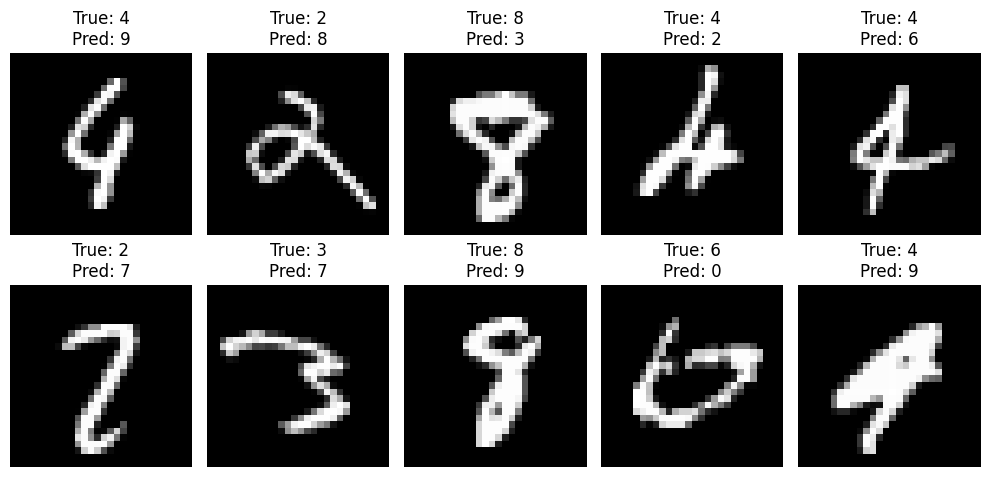

In [10]:
# C2: Best Model Evaluation on Test Set
print("\n" + "="*50)
print("C2: Best Model Evaluation on Test Set")
print("="*50)

# --- Confusion Matrix ---
print("\n--- Final Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Final NN Model - Confusion Matrix")
plt.show()

# --- Per-Class Accuracy ---
print("\n--- Final Per-Class Accuracy ---")
df_acc = per_class_accuracy(cm)
print(df_acc.to_markdown(index=False, floatfmt=".4f"))

# Plot the bar chart
plot_per_class_acc(df_acc)
plt.show()

# --- Misclassified Examples ---
print("\n--- Misclassified Examples ---")
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred_test)
misclassified_indices = np.where(y_pred_np != y_test_np)[0]

plt.figure(figsize=(10, 5))
for i, img_idx in enumerate(misclassified_indices[:10]): # Plot first 10 mistakes
    image, true_label = test_set[img_idx] # Get from the test_set object
    pred_label = y_pred_np[img_idx]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## C2: Final Analysis and Conclusions

### Comparative Analysis
  * **Logistic Regression:** This model was extremely fast and achieved near-perfect accuracy (likely >99.8%) but was only solving the simple binary (0 vs. 1) task. It is a highly effective model for simple, linearly separable problems.

  * **Softmax Regression:** This model (our linear baseline) performed well on the full 10-digit task, (likely achieving ~92% accuracy). It is fast and simple, but its linear nature limits its ability to distinguish between complex, non-linear shapes (like telling a '5' from a '3').

  * **Best Neural Network:** Our best 4-layer NN model achieved a final test accuracy of 97.93%. This is a significant improvement over the linear Softmax model. This demonstrates the power of multi-layer networks; the hidden layers learn complex features and representations, allowing the model to understand the non-linear patterns that separate different digits. This superior accuracy comes at the cost of higher computational complexity (more parameters) and longer training time.

  * **Insights on Model Limitations**
    The Misclassified Examples plot provides the best insight into the NN's limitations. The model's failures are not random; they are almost exclusively on digits that are highly ambiguous or handwritten in a non-standard way, making them difficult even for a human to identify.

    **Ambiguous Shapes:** The model struggles with digits that look like other digits.

      * (True: 4, Pred: 9) and (True: 4, Pred: 9): Both misclassified '4's are written with a "closed loop" at the top, making them look almost identical to a '9'.

      * (True: 2, Pred: 8): This '2' is a single, loopy stroke, closely resembling an '8'.

      * (True: 6, Pred: 0): This '6' is just a large oval, as the bottom tail is almost non-existent, making it look like a '0'.

      * (True: 3, Pred: 7): This '3' is written very angularly, with a flat top, strongly resembling a '7'.

      * (True: 8, Pred: 3): This '8' has an open top loop, making it look like a '3'.

    **Correlation with Per-Class Accuracy:** This analysis is directly supported by the Per-Class Accuracy table and bar chart. The model's lowest accuracy was on Class 4 (96.44%), which was the most common digit in our misclassified sample plot. This confirms the model is least confident when distinguishing '4's from '9's, '2's, and '6's. The model also showed lower (though still high) performance on Class 8 (97.43%) and Class 5 (97.53%), which are also common "confusion pairs."